# Fake news detector

**Disclaimer**: This work is a personal side project and more importantly a work in progress, it is only a quick unfinished review of classic ML method for NLP. It might contain mistakes, don't hesitate to contact me via github if you find one.

In [70]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, SparsePCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix

import re

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/felixgaschi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Presentation of the data

The dataset is drawn from the following Kaggle competition: https://www.kaggle.com/c/fake-news/

It contains the following features:
- id: unique id for a news article
- title: the title of a news article
- author: author of the news article
- text: the text of the article; could be incomplete
- label: a label that marks the article as potentially unreliable
    - 1: unreliable
    - 0: reliable

In [2]:
# Loading files

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

df = train.dropna(subset=["text"])[["id", "text", "label"]]

## Preprocessing

First, we will consider only the content of the article (we might consider their title and author later).

First we must preprocess the contents. 

We will follow the following steps:
- clean the text (remove symbols and digits and set text to lowercase)
- tokenize
- stem
- remove stopwords

In [3]:
# preprocessing function
ps = PorterStemmer()
stop = set(stopwords.words("english"))

def preprocess(text):
    """
    Cleans the text and transforms it into lists
    """
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = text.lower()
    words = word_tokenize(text)
    stems = [ps.stem(w) for w in words if w not in stop]
    return " ".join(stems)

From there we can implement several ML techniques, three of the most popular are:

- Logistic regression
- SVM
- RandomForest

First, we test the logistic regression.

## Logistic regression

As input data, we use the tfidf. I will later use document embedding and compare both data representation.

A small grid search that we did outside of this notebook gave us the following parameters for the TFIDF:
- ngram_range (size of ngram considered) : (1,2) (for computability reasons, I only tested (1,1) and (1,2))
- max_df (the maximum document frequency) : 0.75
- min_df (the minimum document frequency) : 0

I am surprised to find a minimum document frequency of 0, I might do a new grid search with smaller values of min_df later.

A grid search also gave us a value for the constant C of the logistic regression: 1000.

In [73]:
# we build the pipeline
logRegPipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), preprocessor = lambda x: preprocess(x), max_df=0.75, min_df=0.0)),
    ("logreg", LogisticRegression(C=1000))
])

We compute a 3-folds cross validation score. 

In [74]:
scores = cross_val_score(logRegPipe, df["text"], df["label"], cv=3)
print("Mean CV score: ", np.mean(np.array(scores)))

Mean CV score:  0.9605991886411994


### Confusion matrix

To compute a confusion matrix, we create a train/test split of the data.

In [75]:
A, B = train_test_split(df, random_state=42)

In [76]:
logRegPipe.fit(A["text"], A["label"])
y = logRegPipe.predict(B["text"])

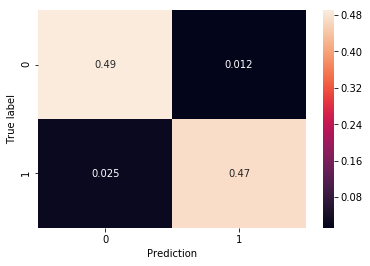

In [77]:
import seaborn as sn

cm = confusion_matrix(B["label"], y) / len(B["label"])
df_cm = pd.DataFrame(cm, columns = [0, 1], index = [0, 1])
sn.heatmap(df_cm, annot=True)
plt.xlabel("Prediction")
plt.ylabel("True label")
plt.show()

There is more unreliable (true label 1) articles predicted as reliable than reliable articles predicted as unreliable.

If we want to broadcast only reliable article, our estimator is not that good. In that case, we might want to do the grid search with an appropriate scoring (the proportion of unreliable articles classified as reliable for example).

To conclude this part about the logistic regression, we can look at the most important coefficient.

### Coefficient of the logistic regression

In [78]:
pipeline = logRegPipe
coefs = pipeline.named_steps["logreg"].coef_.copy()
voc = pipeline.named_steps["tfidf"].vocabulary_

def get_word(voc, index):
    for (elt, i) in voc.items():
        if (i==index):
            return elt
    return None

best = []
worst = []
for i in range(10):
    arg = np.argmax(coefs)
    best.append((get_word(voc, arg), coefs[0, arg]))
    coefs[0, arg] = 0
    
    
    arg = np.argmax(-coefs)
    worst.append((get_word(voc, arg), coefs[0, arg]))
    coefs[0, arg] = 0

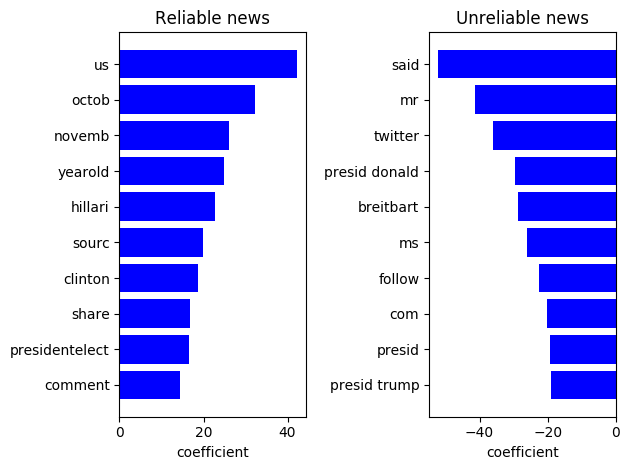

In [79]:
plt.rcdefaults()
fig, axes = plt.subplots(nrows=1, ncols=2)
[ax1, ax2] = axes

# Example data
people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = np.arange(len(people))
performance = 3 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))

y_pos = np.arange(10)
worst_words = [elt[0] for elt in worst]
best_words = [elt[0] for elt in best]
worst_score = [elt[1] for elt in worst]
best_score = [elt[1] for elt in best]

ax1.barh(y_pos, best_score, align='center',
        color='blue', ecolor='black')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(best_words)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_xlabel('coefficient')
ax1.set_title('Reliable news')

ax2.barh(y_pos, worst_score, align='center',
        color='blue', ecolor='black')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(worst_words)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('coefficient')
ax2.set_title('Unreliable news')

plt.tight_layout()
plt.show()

We notice that a few words seem relevant. For example the word "said" is a sign of reliability. It might be due to the fact that reliable articles quotes different people, so the word "said" would appear more.

Nevertheless, most of the words don't seem very relevant. The model seems to be influenced by the events at the time of the creation of the dataset (judging by the presence of the words "obama", "fbi", "clinton", "hillary"). If the model works well on the dataset, it might not be working on different data. Solutions to that could be:
- build a custom stop-words list (remove words based on their grammatical type for example with NLTK) 
- use models based on sentences or sequences of words. For example, we could have increased the n_gram parameter of tfidf, but it would have taken too much time to compute, or we could make our custom word embedding.

A word-based technique seems to have its limits. 

## Get the score of an article online

We use the newspaper3k python module

https://newspaper.readthedocs.io/en/latest/

In [80]:
from newspaper import Article

def give_score(link):
    """Takes an article and outputs the probability
    that it is reliable according to the logistic regression
    (the probability it belongs to class 0)"""
    article = Article(link)
    article.download()
    article.parse()
    text = preprocess(article.text)
    return logRegPipe.predict_proba([text])[0][0]

In [81]:
# try with a BBC article
score = give_score("https://www.nytimes.com/2018/11/06/us/politics/patriotism-midterms-trump.html")
print("reliability: ", score)

reliability:  0.9687695192636089


In [82]:
# and now with an article from The Onion (a parodic online newspaper)
score = give_score("https://politics.theonion.com/north-carolina-voter-in-heavily-gerrymandered-district-1830260864")
print("reliability: ", score)

reliability:  0.496052060219619


In [83]:
# Now with a known fake piece of news from Breitbar
score = give_score("https://www.breitbart.com/the-media/2017/04/19/msnbc-counter-terrorism-analyst-calls-for-isis-bombing-of-trump-property/")
print("reliability: ", score)

reliability:  0.8789563162426713


In [84]:
# Finally an anti-Semite article from Breitbar
score = give_score("https://www.breitbart.com/politics/2016/05/15/bill-kristol-republican-spoiler-renegade-jew/")
print("reliability: ", score)

reliability:  0.0243864755383858


With these few trials, we find that unreliable articles are often classified as reliable (as we have seen with the confusion matrix above). It might be due to the fact that some unreliable article are only unreliable because of the misinformation, but the vocabulary, the tone are the same as in a reliable article. 

## TODO

- apply document embedding
- do the same with SVM and RandomForest
- Try to combine the score of the three estimators to get better results